# Using Prophet For Crypto Price Forecasting

In this notebook, we use [Facebook's Prophet ])(https://facebook.github.io/prophet/) to forecast Bitcoin's future price. Along the way, we use additional information about the Bitcoin network to improve our predictions. As a bonus, we try this on predicting Ethereum's price.

**Disclaimer**: the work in this notebook should not be be used in making financial decisions. Please understand the risks involve when trading cryptocurrencies or any financial instrument.

In [1]:
import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from fbprophet import Prophet

from collections import namedtuple
from itertools import count
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (20, 10)

Importing plotly failed. Interactive plots will not work.


In [2]:
def calculate_performance_metrics(y_true, y_predicted):
    explained_variance = r2_score(y_true, y_predicted)
    rmse = mean_squared_error(y_true, y_predicted, squared=False)
    print(f"Explained variance: {explained_variance}")
    print(f"RMSE: {rmse}")

# Data Loading and Preparation

Data of the Bitcoin network was obtained from [Quandl](https://www.quandl.com/data/BCHAIN-Blockchain). We limit our start date to the 1st of January 2015. For simplicity, we assume that Bitcoins are bought on open. We construct the full dataset including information about the Bitcoin network here.

In [3]:
START_DATE = "2015-01-01"
BASE_DIR = "data/"

In [4]:
btc = pd.read_csv(os.path.join(BASE_DIR, "BTC-USD_full.csv"))
btc["Date"] = pd.to_datetime(btc["Date"], format="%Y-%m-%d")

In [5]:
# unique addresses
addresses = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-NADDU.csv"))
addresses["Date"] = pd.to_datetime(addresses["Date"], format="%Y-%m-%d")
addresses = addresses.loc[addresses["Date"] >= START_DATE]

In [6]:
# difficulty
difficulty = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-DIFF.csv"))
difficulty["Date"] = pd.to_datetime(difficulty["Date"], format="%Y-%m-%d")
difficulty = difficulty.loc[difficulty["Date"] >= START_DATE]

In [7]:
# hashrate
hashrate = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-HRATE.csv"))
hashrate["Date"] = pd.to_datetime(hashrate["Date"], format="%Y-%m-%d")
hashrate = hashrate.loc[hashrate["Date"] >= START_DATE]

In [8]:
# total bitcoins
total_bitcoins = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-TOTBC.csv"))
total_bitcoins["Date"] = pd.to_datetime(total_bitcoins["Date"], format="%Y-%m-%d")
total_bitcoins = total_bitcoins.loc[total_bitcoins["Date"] >= START_DATE]

In [9]:
# transactions excluding popular addresses
xpopular_addresses = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-NTREP.csv"))
xpopular_addresses["Date"] = pd.to_datetime(xpopular_addresses["Date"], format="%Y-%m-%d")
xpopular_addresses = xpopular_addresses.loc[xpopular_addresses["Date"] >= START_DATE]

In [10]:
# average block size in MB
average_block_size = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-AVBLS.csv"))
average_block_size["Date"] = pd.to_datetime(average_block_size["Date"], format="%Y-%m-%d")
average_block_size = average_block_size.loc[average_block_size["Date"] >= START_DATE]

In [11]:
# 13 Week Treasury Bill
t_bill = pd.read_csv(os.path.join(BASE_DIR, "IRX.csv"))
t_bill["Date"] = pd.to_datetime(t_bill["Date"], format="%Y-%m-%d")
t_bill = t_bill.loc[t_bill["Date"] >= START_DATE]
t_bill = t_bill[["Date", "Open"]]
t_bill = t_bill.rename(columns={"Date": "Date", "Open": "TBill"})

In [12]:
# S&P 500
snp500 = pd.read_csv(os.path.join(BASE_DIR, "S&P500.csv"))
snp500["Date"] = pd.to_datetime(snp500["Date"], format="%Y-%m-%d")
snp500 = snp500.loc[snp500["Date"] >= START_DATE]
snp500 = snp500[["Date", "Open"]]
snp500 = snp500.rename(columns={"Date": "Date", "Open": "SnP500"})

In [13]:
additional_regressors = [
    addresses,
    difficulty,
    hashrate,
    total_bitcoins,
    snp500,
    t_bill,
    xpopular_addresses,
    average_block_size,
]

price_addresses = btc[["Date", "Open"]]
for regressor in additional_regressors:
    price_addresses = price_addresses.merge(regressor, on="Date")
price_addresses.dropna(inplace=True)

# Modelling

## Initial model

In our initial model, we only use the price information for prediction. We will try to predict prices after the `PREDICTION_CUTOFF` date.

In [14]:
PREDICTION_CUTOFF = "2021-01-01"

In [15]:
input_df = price_addresses[
    [
        "Date", 
        "Open", 
    ]
]
# column name remapping for Prophet
input_df = input_df.rename(columns={
    "Date": "ds", 
    "Open": "y", 
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

In [16]:
init_model = Prophet(daily_seasonality=False)
init_model.fit(input_df);

In [17]:
train_forecast = init_model.predict(input_df)

In [18]:
# set all non-negative early price forecasts to 0
train_forecast.loc[train_forecast["yhat"] < 0, "yhat"] = 0

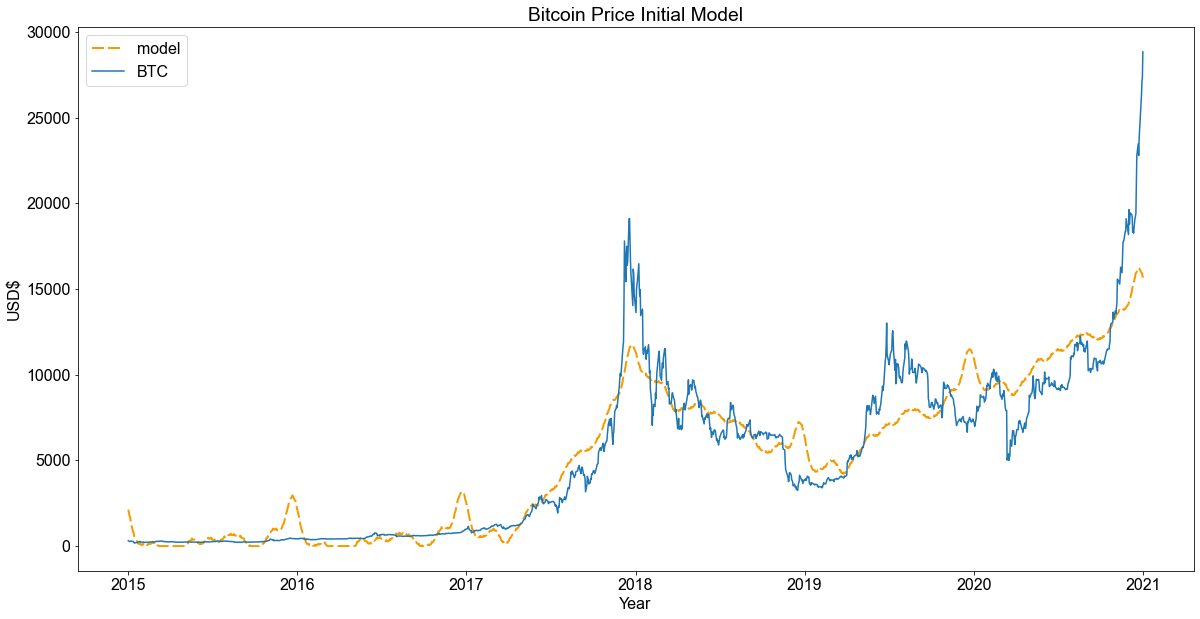

In [19]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots();
ax.plot(train_forecast["ds"], train_forecast["yhat"], dashes=[6, 2], linewidth=2, color="#F59B00", label="model")
ax.plot(train_forecast["ds"], input_df["y"], label="BTC")
plt.xlabel("Year");
plt.ylabel("USD$");
plt.title("Bitcoin Price Initial Model");
plt.legend();

In [20]:
print("Metrics on training set")
calculate_performance_metrics(train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
Explained variance: 0.8469098008869775
RMSE: 1696.1926294833265


### Test set

Let's now predict after the `PREDICTION_CUTOFF` date. 

In [21]:
forecast = init_model.predict(future_df)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15)

,ds,yhat,yhat_lower,yhat_upper
14,2021-01-25,13796.435178,11677.988184,15961.964422
15,2021-01-26,13864.010947,11438.263474,16047.011937
16,2021-01-27,13845.167292,11780.152108,16190.516164
17,2021-01-28,13798.074219,11523.374215,15974.980432
18,2021-01-29,13802.438424,11657.761348,15933.206676
19,2021-02-01,13834.358001,11661.985914,15872.641775
20,2021-02-02,13911.330267,11644.382118,16026.510767
21,2021-02-03,13899.700551,11803.406726,16069.347015
22,2021-02-04,13858.184417,11847.115096,15999.121955
23,2021-02-05,13867.026249,11626.531962,16018.317233


From the above, at most, Bitcoin's price is slightly above USD$16,000 in the test time period (given by `yhat_upper`).

In [22]:
print("Metrics on test set")
calculate_performance_metrics(forecast.loc[:, "yhat"], future_df["y"])

Metrics on test set
Explained variance: -2963.383486787013
RMSE: 22936.084237754658


The explained variance completely breaks down towards the end of January compared to the current price of Bitcoin (which is near USD$50,000 as of the writing of this report).

## Adding Regressors

We can improve our estimates by factoring in additional information i.e., *additional regressors*, to help with predicting the price of Bitcoin. Additional information we can factor are
* the number of unique addresses
* the difficulty of mining as time progresses
* the hash rate
* the total number of bitcoins in circulation
* the S&P 500 index value
* the US 13 week Treasury Bill rate
* the number of transactions excluding popular addresses
* the average block size in MB

Let's look at the correlation of these regressors to the price via the correlation over the whole dataset period.

In [23]:
price_addresses.corr()["Open"]

Open                              1.000000
Addresses                         0.693775
Difficulty                        0.747612
Hash_Rate                         0.755237
Total_Bitcoins                    0.700928
SnP500                            0.847504
TBill                             0.145437
Transactions_Excluding_Popular    0.491946
Average_Block_Size_MB             0.624521
Name: Open, dtype: float64

We can see that these regressors have a correlation to the price. These relationships should help with price prediction.

In [24]:
input_df = price_addresses[
    [
        "Date", 
        "Open", 
        "Addresses", 
        "Difficulty", 
        "Hash_Rate", 
        "Total_Bitcoins", 
        "SnP500", 
        "TBill", 
        "Transactions_Excluding_Popular",
        "Average_Block_Size_MB",
    ]
]
input_df = input_df.rename(columns={
    "Date": "ds", 
    "Open": "y", 
    "Addresses": "addresses",
    "Difficulty": "difficulty",
    "Hash_Rate": "hash_rate",
    "Total_Bitcoins": "total_bitcoins",
    "SnP500": "snp500",
    "TBill": "t_bill",
    "Transactions_Excluding_Popular": "transactions_excluding_popular",
    "Average_Block_Size_MB": "average_block_size_mb",
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

Note that we assume that these regressors are **additive** in nature to the model. There is no basis for this, and certainly some of these regressors could have **multiplicative** effects.  

In [25]:
extended_model = Prophet(daily_seasonality=False)

for col in input_df.columns:
    if col not in ["ds", "y"]:
        extended_model.add_regressor(col, mode="additive")

extended_model.fit(input_df);

In [26]:
train_forecast = extended_model.predict(input_df)

In [27]:
# set all non-negative early price forecasts to 0
train_forecast.loc[train_forecast["yhat"] < 0, "yhat"] = 0

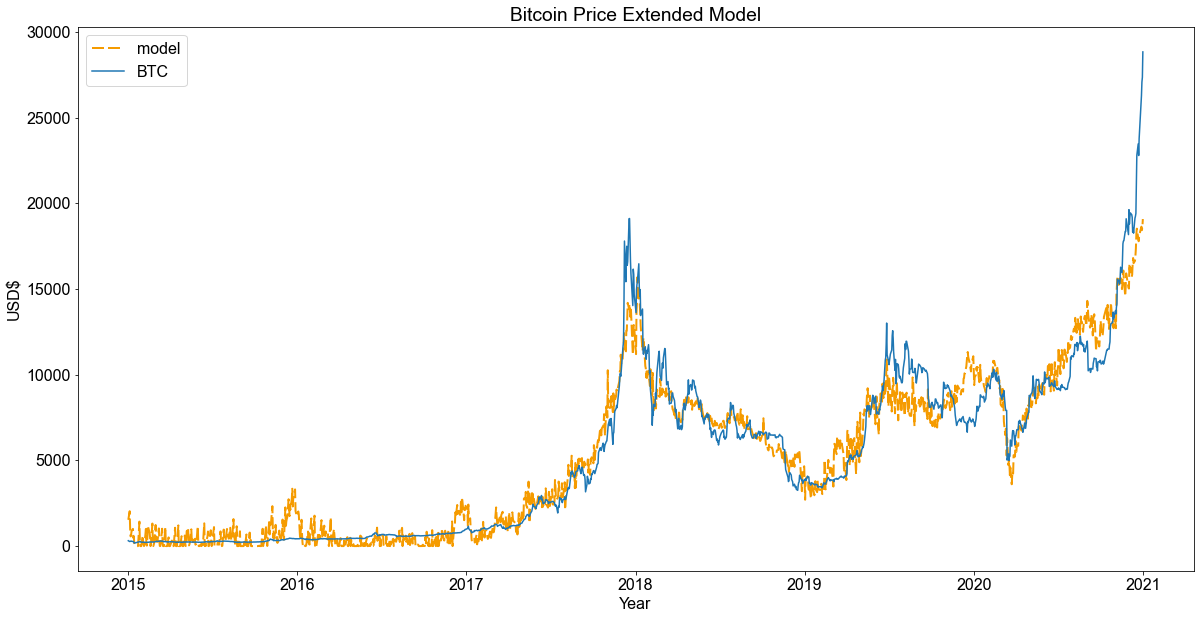

In [28]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots();
ax.plot(train_forecast["ds"], train_forecast["yhat"], dashes=[6, 2], linewidth=2, color="#F59B00", label="model")
ax.plot(train_forecast["ds"], input_df["y"], label="BTC")
plt.xlabel("Year");
plt.ylabel("USD$");
plt.title("Bitcoin Price Extended Model");
plt.legend();

Again, we can see a huge departure from the model towards the end of 2020. But we can also see that the explained variance is much higher as compared to our initial model.

In [29]:
print("Metrics on training set")
calculate_performance_metrics(train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
Explained variance: 0.9200854176090233
RMSE: 1273.4182844582183


In [30]:
forecast = extended_model.predict(future_df)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15)

,ds,yhat,yhat_lower,yhat_upper
14,2021-01-25,16643.042290,15015.134406,18349.589118
15,2021-01-26,17211.028100,15469.575021,18726.061664
16,2021-01-27,17089.635071,15481.302441,18786.867517
17,2021-01-28,17354.865923,15643.740852,19007.611421
18,2021-01-29,17159.285528,15523.257703,18811.989416
19,2021-02-01,17875.535648,16271.163341,19597.297120
20,2021-02-02,17505.649684,15775.729481,19010.253999
21,2021-02-03,18417.315583,16666.920285,20070.262238
22,2021-02-04,18339.911246,16781.696960,20097.305826
23,2021-02-05,19118.431190,17430.978735,20799.600294


From the above, at most, Bitcoin's price is slightly above USD$20,000 in the test time period (given by `yhat_upper`). Below, we see that the explained variance completely breaks down towards the end of January.

In [31]:
print("Metrics on test set")
calculate_performance_metrics(forecast.loc[:, "yhat"], future_df["y"])

Metrics on test set
Explained variance: -430.95767575172573
RMSE: 19026.9806994497


### Decomposition

Prophet can decompose the underlying trends of the price as a function of time. 

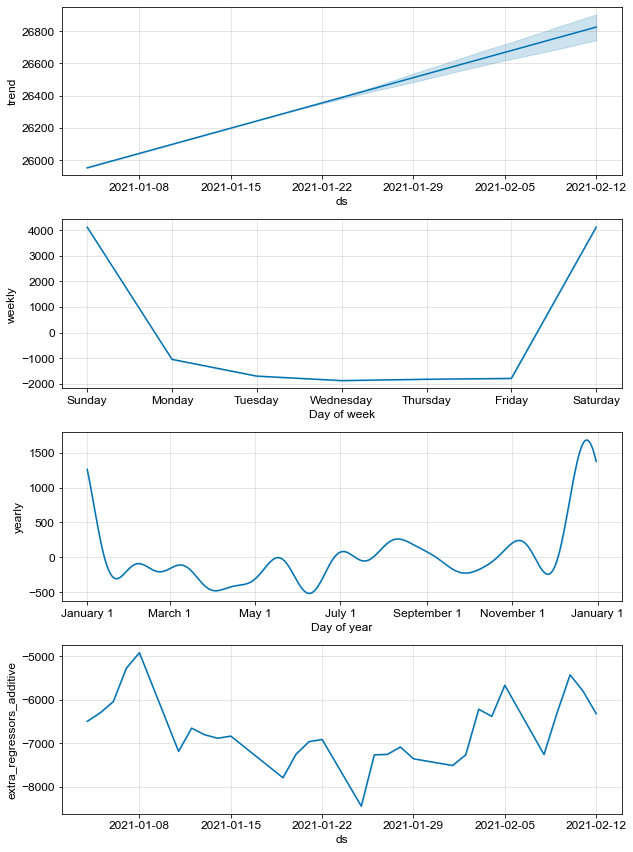

In [32]:
plt.rc("font", family="arial", size=12)
fig = extended_model.plot_components(forecast)

According to the extended model, it is better to buy Bitcoin between Wednesdays and Fridays, as the price peaks on the weekend.

# Bonus: Ethereum Price Model

We can apply the concept to forecasting Ethereum price too. We now start from the 1st of January 2016 instead, as Ethereum's history is not as long as Bitcoin's.

In [33]:
START_DATE = "2016-01-01"

In [34]:
eth = pd.read_csv(os.path.join(BASE_DIR, "ETH_USD.csv"))
eth["Date"] = pd.to_datetime(eth["Date"], format="%Y-%m-%d")

In [35]:
eth_addresses = pd.read_csv("data/crypto/eth_active_addresses_daily.csv")
eth_addresses["Date"] = pd.to_datetime(eth_addresses["Date"], format="%m/%d/%Y")
eth_addresses = eth_addresses.loc[eth_addresses["Date"] >= START_DATE]

In [36]:
eth_price_addresses = eth.merge(eth_addresses, on="Date")
eth_price_addresses.dropna(inplace=True)

## Ethereum Price Model

We use the total unique addresses the Ethereum network has as a regressor for our model.

In [37]:
input_df = eth_price_addresses[
    [
        "Date", 
        "24h Open (USD)", 
        "Unique Address Total Count",
    ]
]
input_df = input_df.rename(columns={
    "Date": "ds", 
    "24h Open (USD)": "y", 
    "Unique Address Total Count": "addresses",
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

In [38]:
eth_model = Prophet(daily_seasonality=False)
eth_model.add_regressor("addresses", mode="additive")

eth_model.fit(input_df);

In [39]:
train_forecast = eth_model.predict(input_df)

In [40]:
# set all non-negative early price forecasts to 0
train_forecast.loc[train_forecast["yhat"] < 0, "yhat"] = 0

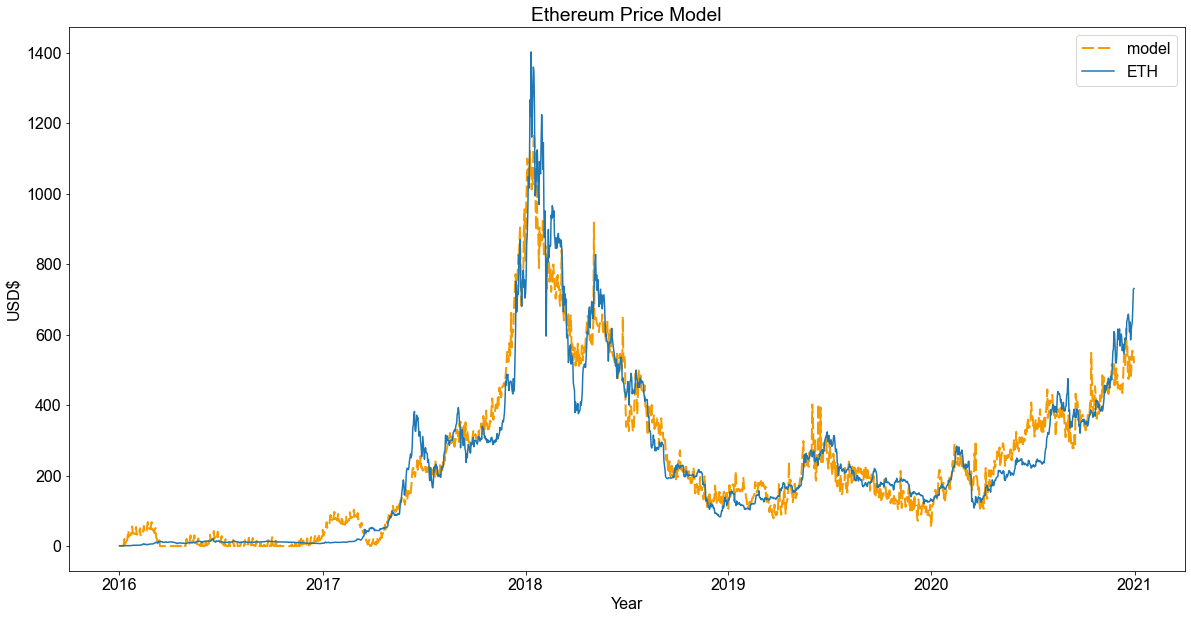

In [41]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots();
ax.plot(train_forecast["ds"], train_forecast["yhat"], dashes=[6, 2], linewidth=2, color="#F59B00", label="model")
ax.plot(train_forecast["ds"], input_df["y"], label="ETH")
plt.xlabel("Year");
plt.ylabel("USD$");
plt.title("Ethereum Price Model");
plt.legend();

In [42]:
print("Metrics on training set")
calculate_performance_metrics(train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
Explained variance: 0.9216162342707956
RMSE: 61.2364837682507


In [43]:
forecast = eth_model.predict(future_df)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15)

,ds,yhat,yhat_lower,yhat_upper
28,2021-01-29,698.557976,614.723316,780.883815
29,2021-01-30,680.651418,599.155991,760.043426
30,2021-01-31,664.803923,584.591480,746.822651
31,2021-02-01,666.865319,584.981933,742.303698
32,2021-02-02,688.754816,612.924730,767.520282
33,2021-02-03,718.884066,638.771828,794.723805
34,2021-02-04,702.893285,620.720613,780.446977
35,2021-02-05,688.791836,607.803620,766.737604
36,2021-02-06,680.485819,597.336401,766.675097
37,2021-02-07,686.439099,604.540087,769.733019


In [44]:
print("Metrics on test set")
calculate_performance_metrics(forecast.loc[:, "yhat"], future_df["y"])

Metrics on test set
Explained variance: -260.5736303498112
RMSE: 671.6593684351635


### Decomposition 

Here, we decompose the price action of Ethereum.

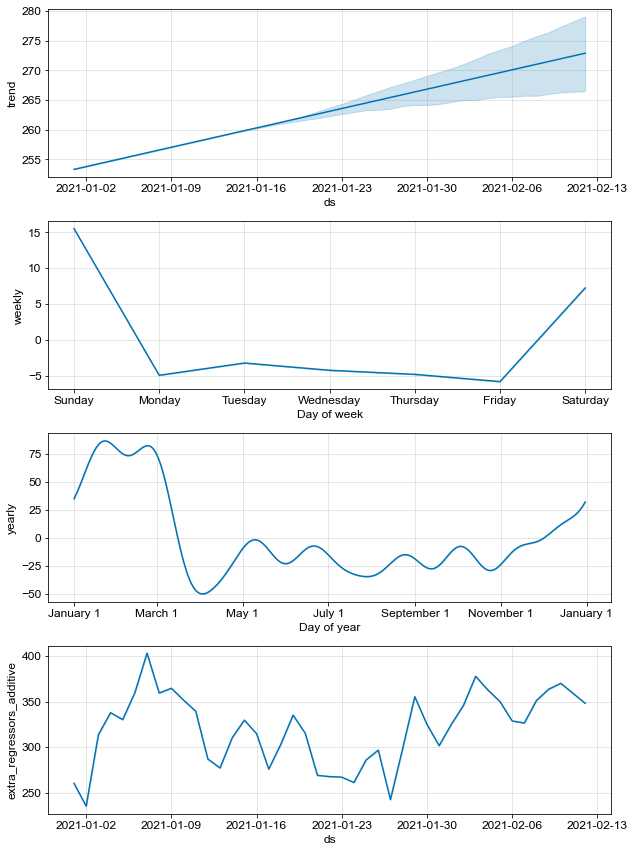

In [45]:
plt.rc("font", family="arial", size=12)
fig = eth_model.plot_components(forecast)

The observations here are the same as that for Bitcoin.

# Conclusions

Predicting prices of an asset is highly challenging. If we assume our model to be a predictor of the intrinsic valuve of Bitcoin and Ethereum, then both these cryptocurrencies are overvalued towards the end of January 2021. We will not go into a discourse on the concept of value with respect to cryptocurrencies. We shall only mention that our model shows that the current price action is a large departure from what is expected based on Prophet's model assumptions.

Here are several issues to consider:
* **price non-negativity**: Prophet at present does not provide a facility to factor in constraints on the time series to be forecasted. We know that price is at least $0, but Prophet does not allow for this prior information without some modifications to the underlying code (see [here](https://github.com/facebook/prophet/issues/1405) and [here](https://github.com/alexander-pv/prophet/blob/develop/test_constrained_model.ipynb) for example).
* **multiplicative regressors**: we assume all regressors are additive. It will take more work and rigourous cross-validation to determine which regressors are potentially multiplicative.
* **ceiling on coins in circulation**: Bitcoin is unique in that there is ultimately a ceiling on the number of Bitcoins there could ever be: exactly 21 million. We could improve our model by including this constraint into our model.